<center> <h1>Implementing the indirect simple shooting method</h1> </center>
<center> <h2>Réalisation : Habibi Issam - Sajid Badr</h2> </center>

* Author: Olivier Cots
* Date: March 2021

------

## The energy min 2D integrator problem with friction and simple limit conditions

Consider the following optimal control problem (Lagrange cost, fixed final time):

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \frac{1}{2} \int_0^{1} u^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = (x_2(t), -\mu x_2^2(t) + u(t)), \quad  u(t) \in \mathrm{R}, \quad t \in [0, 1] \text{ a.e.},    \\[1.0em]
        x(0) = (-1, 0), \quad x(1) = (1, 0).
    \end{array}
    \right. 
$$

We consider the normal case ($p^0 = -1$), so the pseudo-Hamiltonian of the problem is

$$
    H(x,p,u) = p_1 x_2 + p_2 (-\mu x_2^2 + u) - \frac{1}{2} u^2.
$$

We denote by $t_0$, $t_f$ and $x_0$ the initial time, final time and initial condition.

<div class="alert alert-warning">

**Main goal**

Code the simple shooting method to solve this optimal control problem.
    
</div>

Steps:

1. Use nutopy package to solve the problem: see this [page](https://ct.gitlabpages.inria.fr/gallery/shooting_tutorials/simple_shooting_general.html) for a general presentation of the simple shooting method with the use of nutopy package. See this [page](https://ct.gitlabpages.inria.fr/gallery/smooth_case/smooth_case.html) for a more detailed use of nutopy package on a smooth example.
2. Replace the [numerical integrator](https://en.wikipedia.org/w/index.php?title=Numerical_integration&oldid=1000975450). It is asked to code Euler (order 1) and Runge (order 2) methods and a Runge-Kutta method of order 4.
3. Replace the [Newton solver](https://en.wikipedia.org/wiki/Newton%27s_method). It is asked to code a simple version of a Newton solver.

## Preliminaries

In [1]:
# Import packages
#
import nutopy as nt
import nutopy.tools as tools
import nutopy.ocp as ocp
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150

In [2]:
# Parameters
# This parameters are used all through the notebook.
#
t0          = 0.0                   # initial time
tf          = 1.0                   # final time
x0          = np.array([-1.0, 0.0]) # initial condition
xf_target   = np.array([1.0, 0.0])  # final target
mu          = 0.5                   # friction parameter
dimx        = x0.shape[0]           # dimension of the state space

## Step 1: Resolution of the shooting function with nutopy

The maximized Hamiltonian is

$$
    h(x, p) = H(x, p, u[x, p]) = x_2 p_1 - \mu x_2^2 p_2 + \frac{1}{2} p_2^2, \quad z = (x, p),
$$

where $u[x, p] = p_2$ is the maximizing control in feedback form.

In [3]:
# Maximized Hamiltonian with its derivatives and its flow
def hfun(t, x, p):
    x2 = x[1]
    p1 = p[0]
    p2 = p[1]
    h  = p1*x2-mu*x2**2*p2+0.5*p2**2 
    return h

def dhfun(t, x, dx, p, dp):
    x2  = x[1]
    dx2 = dx[1]
    p1  = p[0]
    p2  = p[1]
    dp1 = dp[0]
    dp2 = dp[1]
    hd  = dp1*x2+p1*dx2-2.0*mu*x2*dx2*p2-mu*x2**2*dp2+p2*dp2
    return hd

def d2hfun(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    x2   = x[1]
    dx2  = dx[1]
    d2x2 = d2x[1]
    p1   = p[0]
    p2   = p[1]
    dp1  = dp[0]
    dp2  = dp[1]
    d2p1 = d2p[0]
    d2p2 = d2p[1]
    hdd  =    dp1*d2x2 \
            + d2p1*dx2 \
            - 2.0*mu*d2x2*dx2*p2 - 2.0*mu*x2*dx2*d2p2 \
            - 2.0*mu*x2*d2x2*dp2 \
            + d2p2*dp2
    return hdd

hfun = nt.tools.tensorize(dhfun, d2hfun, tvars=(2, 3))(hfun)
h    = ocp.Hamiltonian(hfun)   # The Hamiltonian object
f    = ocp.Flow(h)             # The flow associated to the Hamiltonian object is 
                               # the exponential mapping with its derivative
                               # that can be used to define the Jacobian of the 
                               # shooting function

The shooting function is given by

$$
    S(p_0) = \pi_x(z(t_f, x_0, p_0)) - x_f,
$$

where $x_f = (1, 0)$ is the target, where $\pi_x(x,p) := x$ is the canonical projection into the state space and where $z(t_f, x_0, p_0)$ is the solution at time $t_f$ of 

$$
    \dot{z}(t) = \vec{H}(z(t), u[z(t)]) = \vec{h}(z(t)), \quad z(0) = (x_0, p_0),
$$

with $\vec{H}(z, u) := (\nabla_p H(z,u), -\nabla_x H(z,u))$ and $\vec{h}(z) := (\nabla_p h(z), -\nabla_x h(z))$.

In [4]:
# Shooting function and its derivative
def dshoot(p0, dp0):
    (xf, dxf), _ = f(t0, x0, (p0, dp0), tf)
    s  = xf - xf_target # code duplication (in order to compute dxf, shooting also needs to compute xf;
                        # accordingly, full=True)
    ds = dxf
    return s, ds

@tools.tensorize(dshoot, full=True)
def shoot(p0):
    xf, _ = f(t0, x0, p0, tf)
    s = xf - xf_target
    return s

We solve with the nutopy package
$$
    S(p_0) = 0.
$$

In [5]:
# Resolution of the shooting function S(p0) = 0
#
p0_guess = np.array([0.1, 0.1])
sol = nt.nle.solve(shoot, p0_guess, df=shoot); p0_nutopy = sol.x
print(' p0_nutopy        =', p0_nutopy, \
      '\n shoot(p0_nutopy) =', shoot(p0_nutopy))


     Calls  |f(x)|                 |x|
 
         1  1.967300768937284e+00  1.414213562373095e-01
         2  1.719731572785037e+00  1.798534093044436e+01
         3  1.410906422430211e+00  3.487107124079308e+01
         4  1.991207495319282e+00  3.937341638076422e+01
         5  7.277880985715982e-01  3.625515294040530e+01
         6  4.725619938021095e-01  3.555941926121004e+01
         7  3.166103150678147e-02  3.433969876028567e+01
         8  2.245063172754588e-03  3.442461252396225e+01
         9  6.943644107728013e-04  3.442864514091167e+01
        10  1.078577109865398e-04  3.442751328490402e+01
        11  2.201216767879966e-07  3.442730460220397e+01
        12  2.084484933152670e-09  3.442730418046803e+01
        13  1.938651563244826e-11  3.442730418446997e+01

 Results of the nle solver method:

 xsol    =  [31.89425568 12.96131661]
 f(xsol) =  [4.30899760e-12 1.89015747e-11]
 nfev    =  13
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative er

In [6]:
# Functions needed to plot the solution
@tools.vectorize(vvars=(1,))
def ufun(p):
    u = p[1] # u = p2
    return u

def plotSolution(p0):

    N      = 100
    tspan  = list(np.linspace(t0, tf, N+1))
    xf, pf = f(t0, x0, p0, tspan)
    u      = ufun(pf)

    fig = plt.figure()
    ax  = fig.add_subplot(711); ax.plot(tspan, xf); ax.set_xlabel('t'); ax.set_ylabel('$x$'); ax.axhline(0, color='k')
    ax  = fig.add_subplot(713); ax.plot(tspan, pf); ax.set_xlabel('t'); ax.set_ylabel('$p$'); ax.axhline(0, color='k')
    ax  = fig.add_subplot(715); ax.plot(tspan,  u); ax.set_xlabel('t'); ax.set_ylabel('$u$'); ax.axhline(0, color='k')
    
    x1  = np.zeros(N+1)
    x2  = np.zeros(N+1)
    for i in range(0, N+1):
        x1[i] = xf[i][0]
        x2[i] = xf[i][1]
    
    ax  = fig.add_subplot(717); ax.plot(x1,  x2); ax.set_xlabel('x1'); ax.set_ylabel('$x2$'); ax.axhline(0, color='k')

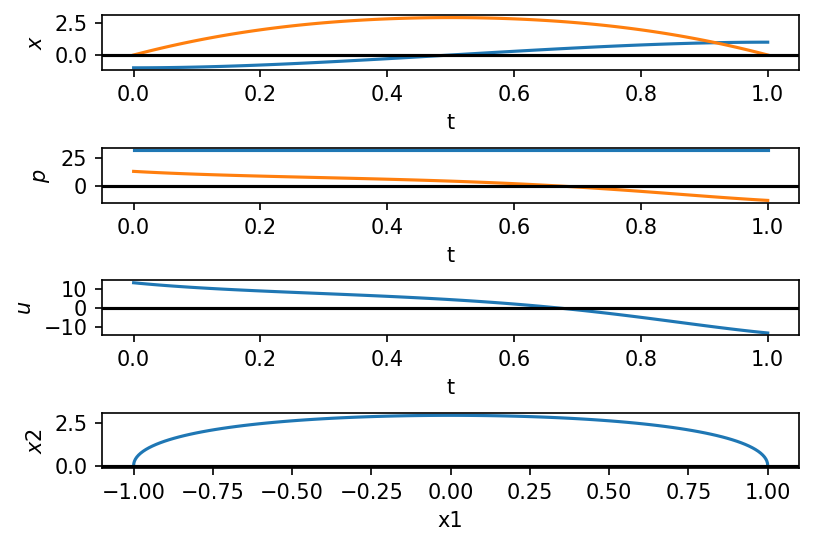

In [7]:
# Plot solution
plotSolution(p0_nutopy)

## Step 2: Replacing the numerical integrator

Let us consider an Initial Value Problem (IVP) or Cauchy problem of the form

$$
\begin{equation}
    \tag{IVP}
    \dot{x}(t) = f(t, x(t)), \quad x(t_0) = x_0,
    \label{eq:ivp}
\end{equation}
$$

with $f : \Omega \in \mathrm{R} \times \mathrm{R}^n \to \mathrm{R}^n$, 
$\Omega$ an open set and $(t_0, x_0) \in \Omega$. Let us assume that $f$ is **continuous**.

**_Definition._**  We call a solution of $\eqref{eq:ivp}$ any pair $(I, x)$ such that $I$ is an open interval of $\mathrm{R}$ containing $t_0$, $x : I \to \mathrm{R}^n$ is a differentiable mapping on $I$ and such that:

* $(t, x(t)) \in \Omega$, $\forall t \in I$,
* $\dot{x}(t) = f(t, x(t))$, $\forall t \in I$,
* $x(t_0) = x_0$.

Such a solution is also called an *integral curve* of the differential equation $\dot{x}(t) = f(t, x(t))$.

**_Differential equation vs. integral equation._** The differential equation $\dot{x}(t) = f(t, x(t))$ with the initial condition $x(t_0) = x_0$ is equivalent to the *integral equation* (see [the fundamental theorem of calculus](https://en.wikipedia.org/wiki/Fundamental_theorem_of_calculus))

$$
    x(t) = x_0 + \int_0^s f(s, x(s)) ~\mathrm{d}s.
$$

**_Remark._** If $f$ is continuous (resp. $C^k$) and $(I, x)$ is a solution, then $x$ is $C^1$ (resp. $C^{k+1})$ on $I$.

<div class="alert alert-warning">

**Goal**

Compute a numerical approximation of a solution $(I, x)$.
    
</div>

We consider a partition $t_0 < t_1 < \cdots < t_N = t_f$, $[t_0, t_f] \subset I$. Let $h_i := t_{i+1}-t_i$ denote the time steps (not necessarily equal) for $i = 0, \cdots, N-1$ and $h_\mathrm{max} = \max_i(h_i)$ the longest step.
The goal is to compute iteratively approximations of $x(t_1), \cdots, x(t_N)$ that we will denote by $x_1, \cdots, x_N$.

### Preliminaries

In [8]:
# Parameters for integration
Nsteps = 10 # Number of integration steps

### Euler

The [Euler scheme](https://en.wikipedia.org/wiki/Euler_method) is simply given by the following approximation of the integral:

$$
    \int_{t_i}^{t_{i+1}} f(s, x(s)) ~\mathrm{d}s \approx h_i f(t_i, x_i).
$$

Hence the Euler scheme is given by

$$
    x_{i+1} = x_i + h_i f(t_i, x_i).
$$


<div class="alert alert-info">

**_Question 1:_**
    
Complete the code of `ode_euler` (see the documentation of the function for details).
      
</div>

In [9]:
# ----------------------------
# Answer 1 to complete here
# ----------------------------
#
# Euler integrator
#
def ode_euler(f, t0, x0, tf, N):
    """
        Computes the approximated solution at time tf of 

            dx = f(t, x), x(t0) = x0
            
        with the Euler scheme and uniform step size.
        
        Inputs: 
        
            - f  : dynamics
            - t0 : initial time, float
            - x0 : initial condition, array
            - tf : final time, float
            - N  : number of steps, integer
            
        Outputs:
        
            - x  : the solution x(tf)     
    """
    
    tspan = np.linspace(t0, tf, N+1)
    h = (tf-t0)/N
    x = x0
    
    ### TO COMPLETE
    for i in range(1,N+1):
        x += h*f(tspan[i],x)
    ###
        
    return x

# Test of the Euler integrator
# We have x(t) = (cos(t), -sin(t))
t = np.pi
x = ode_euler(lambda t, x: np.array([x[1], -x[0]]), 0.0, np.array([1.0, 0.0]), t, 100)
print(' ||(cos(t), -sin(t)) - x|| = ', np.array([np.cos(t), -np.sin(t)])-x, \
      '\t t = ', t)

 ||(cos(t), -sin(t)) - x|| =  [0.05055979 0.00108516] 	 t =  3.141592653589793


<div class="alert alert-info">

**_Question 2:_**
    
Complete the code of `hvfun` implementing the Hamiltonian system $\vec{H}(z(t), u[z(t)]) = \vec{h}(z(t))$.
      
</div>

In [10]:
# ----------------------------
# Answer 2 to complete here
# ----------------------------
#
# Hamiltonian system
#
def hvfun(t, z):
    n  = dimx
    x  = z[0:n]
    p  = z[n:2*n]
    ### TO COMPLETE
    x2  = x[1]
    p1  = p[0]
    p2  = p[1]
    hv = np.array([x2, p2 - mu*(x2**2), 0.0, -p1 + 2*mu*p2*x2])
    return hv

<div class="alert alert-info">

**_Question 3:_**
    
Complete the code of `shoot_euler` implementing the shooting function using `ode_euler` for integration.
      
</div>

In [11]:
# ----------------------------
# Answer 3 to complete here
# ----------------------------
#
# Shooting function with Euler method
#
def shoot_euler(p0):
    n  = dimx
    z0 = np.hstack((x0, p0))
    ### TO COMPLETE
    zf = ode_euler(hvfun, t0, z0, tf, Nsteps)
    xf = zf[0:n]
    s  = xf - xf_target
    ###
    return s

In [12]:
# Resolution of the shooting function
p0_guess = np.array([0.1, 0.1])
sol_euler = nt.nle.solve(shoot_euler, p0_guess); p0_euler = sol_euler.x

# we compare the solution with the one obtained with nutopy
# we call the shooting function from nutopy
print(' p0_euler               =', p0_euler, \
      '\n ||p0_euler-p0_nutopy|| =', np.linalg.norm(p0_euler-p0_nutopy), \
      '\n shoot(p0_euler)        =', shoot(p0_euler))


     Calls  |f(x)|                 |x|
 
         1  1.967806967940155e+00  1.414213562373095e-01
         2  7.763352078391242e-01  1.925483764232603e+01
         3  8.714030918936800e-01  3.049871913351400e+01
         4  5.872090745406082e-01  3.560501399402753e+01
         5  2.014006521293087e-01  3.231327643632874e+01
         6  1.931710384142391e-03  3.316264831206244e+01
         7  8.043024319278244e-05  3.317049712945209e+01
         8  1.579715263727760e-06  3.317019011559066e+01
         9  3.292283942567928e-09  3.317019601604508e+01
        10  1.643167583551767e-13  3.317019600377284e+01

 Results of the nle solver method:

 xsol    =  [30.73610989 12.47210694]
 f(xsol) =  [-1.70974346e-14 -1.63424829e-13]
 nfev    =  10
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

 p0_euler               = [30.73610989 12.47210694] 
 ||p0_euler-p0_nutopy|| = 1.2572301914908524 
 shoot(p0_euler

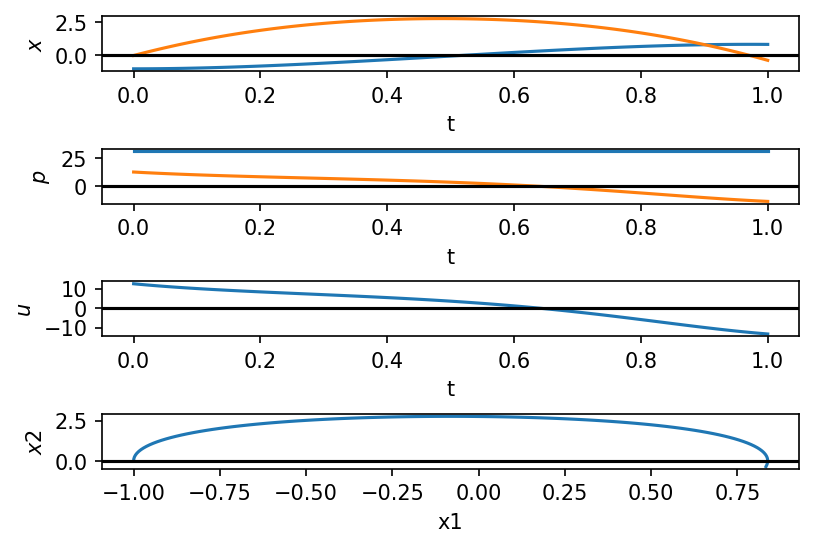

In [13]:
# Plot solution
plotSolution(p0_euler)

### Runge

We can show for the Euler method that the global error $||x_N - x(t_f)||$ behaves like $Ch_\mathrm{max}$, where $C$ is a constant depending on the problem and $h_\mathrm{max}$ is the maximal step size. Hence, if we want a precision of 6 decimals for instance, then, one would need about a million steps, which is not very satisfactory. The obvious idea to improve the numerical accuracy is to approximate the integral by a quadrature formulae of higher order. If we exploit the middle point, we have

$$
    x(t_{i+1}) \approx x_i + h_i f(t_i + \frac{h_i}{2}, x(t_i + \frac{h_i}{2})).
$$

The problem here is that we do not know the value of $x(t_i + \frac{h_i}{2})$. At this stage, the idea is to approximate it by an Euler step: $x(t_i + \frac{h_i}{2}) \approx x_i + \frac{h_i}{2} f(t_i, x_i)$. At the end, we obtain what we call the [Runge scheme](https://en.wikipedia.org/wiki/Midpoint_method) (or midpoint method):

$$
     x_{i+1} = x_i + h_i f(t_i + \frac{h_i}{2}, x_i + \frac{h_i}{2} f(t_i, x_i)).
$$

Using the Runge, we can show that the global error is bounded by $Ch_\mathrm{max}^2$. Hence, to obtain a precision of 6 digits, a thousands steps will usually do.

<div class="alert alert-info">

**_Question 4:_**
    
Complete the code of `ode_runge` (see the documentation of the function for details).
      
</div>

In [14]:
# ----------------------------
# Answer 4 to complete here
# ----------------------------
#
#  Runge integrator
#
def ode_runge(f, t0, x0, tf, N):
    """
        Computes the approximated solution at time tf of 

            dx = f(t, x), x(t0) = x0
            
        with the Runge scheme and uniform step size.
        
        Inputs: 
        
            - f  : dynamics
            - t0 : initial time, float
            - x0 : initial condition, array
            - tf : final time, float
            - N  : number of steps, integer
            
        Outputs:
        
            - x  : the solution x(tf)    
    """
    tspan = np.linspace(t0, tf, N+1)
    h = (tf-t0)/N
    x = x0
    
    ### TO COMPLETE
    for i in range(1,N+1):
        x += h*f(tspan[i]+h/2, x + h*f(tspan[i], x)/2);
    ###
    
    return x

# Test of the Runge integrator
# We have x(t) = (cos(t), -sin(t))
t = np.pi
x = ode_runge(lambda t, x: np.array([x[1], -x[0]]), 0.0, np.array([1.0, 0.0]), t, 100)
print(' ||(cos(t), -sin(t)) - x|| = ', np.array([np.cos(t), -np.sin(t)])-x, \
      '\t t = ', t)

 ||(cos(t), -sin(t)) - x|| =  [ 1.20427602e-05 -5.16624482e-04] 	 t =  3.141592653589793


In [15]:
# Shooting function with Runge method
def shoot_runge(p0):
    n  = dimx
    z0 = np.hstack((x0, p0))
    zf = ode_runge(hvfun, t0, z0, tf, Nsteps)
    xf = zf[0:n]
    s  = xf - xf_target
    return s

In [16]:
# Resolution of the shooting function
p0_guess = np.array([0.1, 0.1])
sol_runge = nt.nle.solve(shoot_runge, p0_guess); p0_runge = sol_runge.x

# we compare the solution with the one obtained with nutopy
# we call the shooting function from nutopy
print(' p0_runge               =', p0_runge, \
      '\n ||p0_runge-p0_nutopy|| =', np.linalg.norm(p0_runge-p0_nutopy), \
      '\n shoot(p0_runge)        =', shoot(p0_runge))


     Calls  |f(x)|                 |x|
 
         1  1.967134895295981e+00  1.414213562373095e-01
         2  1.767925240530967e+00  1.799940022905573e+01
         3  1.259960259144468e+00  3.478958349066952e+01
         4  1.729469341852931e+00  3.830379709452797e+01
         5  7.454299618763681e-01  3.575955343995667e+01
         6  4.995424447550748e-01  3.510337739286172e+01
         7  1.863642739895163e-02  3.381938420706238e+01
         8  2.220983908854785e-03  3.387938502752595e+01
         9  4.633520849820257e-04  3.388375606015803e+01
        10  3.201130105575809e-05  3.388288851655970e+01
        11  3.067154905436612e-08  3.388282399525519e+01
        12  2.467268656218346e-10  3.388282393446912e+01

 Results of the nle solver method:

 xsol    =  [31.39989788 12.73154235]
 f(xsol) =  [5.20279375e-11 2.41178855e-10]
 nfev    =  12
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

 p

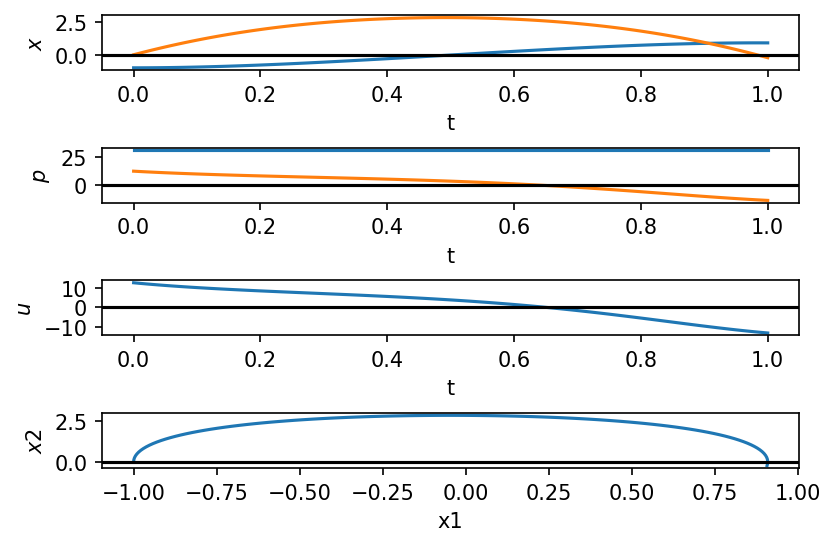

In [17]:
# Plot solution
plotSolution(p0_runge)

### Rk4

The Euler method is a order 1 method while the Runge method is of order 2. A method of order $p$ has a global error bounded by $Ch_\mathrm{max}^p$. To improve the numerical accuracy we can continue and define new methods of higher orders. The main method of order 3 is given by the [Heun scheme](https://en.wikipedia.org/wiki/Heun%27s_method). In this part, we will implement a method of order 4 simply called *rk4 method*. The Euler, Runge, Heun and rk4 methods are parts of what we call  explicit [Runge-Kutta](https://en.wikipedia.org/wiki/Runge–Kutta_methods) methods.

**_Remark_.** In the following definition, we give only the first iteration: $x_1 = x_0 + h \Phi(t_0, x_0, h)$.

**_Definition._** Let $s$ be an integer (the number of *stages*). 
We call a *s-stages explicit Runge-Kutta* method for (IVP), a method defined by the scheme

$$
\begin{equation}\label{eq:Runge-Kutta}
\begin{array}{l}
k_1=f(t_0,x_0)\\
k_2=f(t_0+c_2h,x_0+ha_{21}k_1)\\
\vdots\\
k_s=f(t_0+c_sh,x_0+h\sum_{i=1}^{s-1}a_{si}k_i)\\
x_1=x_0+h\sum_{i=1}^{s}b_ik_i
\end{array}
\end{equation}
$$

where the coefficients $c_i$, $a_{ij}$ and $b_i$ are constants.

**_Assumptions._** We introduce $c_1=0$ and assume that $c_i=\sum_{j=1}^{i-1}a_{ij}$ for $i=2,\ldots,s$.

A Runge-Kutta method is represented in practice by its *Butcher table*:

$$
\begin{array}{c|ccccc}
c_1 & & & & &\\
c_2 & a_{21} & & & & \\
c_3 & a_{31} & a_{32} & & &\\
\vdots & \vdots & \vdots & \ddots & & \\ 
c_s & a_{s1} & a_{s2} & \ldots & a_{ss-1} &    \\ \hline
    & b_1    & b_2    & \ldots & b_{s-1}  & b_s\\
\end{array}
$$

We give the following Butcher tables:

$$
\begin{array}[t]{cccc}
\begin{array}{c}
\\ \\ \\
\begin{array}{c|c}
0 &   \\\hline
& 1
\end{array}
\end{array}
& 
\begin{array}{c}
\\ \\
\begin{array}{c|cc}
0 &  &\\
1/2 & 1/2 &\\ \hline
 & 0 & 1
\end{array}
\end{array}
&
\begin{array}{c}
\\
& \begin{array}{c|ccc}
0 &  &  & \\
1/3 & 1/3 & & \\
2/3 & 0 & 2/3 & \\ \hline
 & 1/4 & 0 & 3/4
\end{array}
\end{array}
& 
\begin{array}{c|cccc}
0 &  &  & &\\
1/2 & 1/2 & & &\\
1/2 & 0 & 1/2 & &\\ 
1 &   0 & 0   & 1 &\\ \hline
 & 1/6 & 2/6 & 2/6 & 1/6
\end{array} \\
\textrm{Euler (order 1)} & \textrm{Runge (order 2)} & \textrm{Heun (order 3)} & \textrm{rk4 method (order 4)}
\end{array}
$$


<div class="alert alert-info">

**_Question 5:_**
    
Complete the code of `ode_rk4` (see the documentation of the function for details).
      
</div>

In [18]:
# ----------------------------
# Answer 5 to complete here
# ----------------------------
#
#   RK4 integrator
#
def ode_rk4(f, t0, x0, tf, N):
    """
        Computes the approximated solution at time tf of 

            dx = f(t, x), x(t0) = x0
            
        with the rk4 scheme and uniform step size.
        
        Inputs: 
        
            - f  : dynamics
            - t0 : initial time, float
            - x0 : initial condition, array
            - tf : final time, float
            - N  : number of steps, integer
            
        Outputs:
        
            - x  : the solution x(tf)    
    """
    tspan = np.linspace(t0, tf, N+1)
    h = (tf-t0)/N
    x = x0
    
    ### TO COMPLETE
    for i in range(1,N+1):
        k1 = f(tspan[i], x);
        k2 = f(tspan[i] + h/2, x + h*k1/2);
        k3 = f(tspan[i] + h/2, x + h*k2/2);
        k4 = f(tspan[i] + h, x + h*k3);
        x += (h/6)*(k1 + 2*k2 + 2*k3 + k4);
    ###
    
    return x

# Test of the RK4 integrator
# We have x(t) = (cos(t), -sin(t))
t = np.pi
x = ode_rk4(lambda t, x: np.array([x[1], -x[0]]), 0.0, np.array([1.0, 0.0]), t, 100)
print(' ||(cos(t), -sin(t)) - x|| = ', np.array([np.cos(t), -np.sin(t)])-x, \
      '\t t = ', t)

 ||(cos(t), -sin(t)) - x|| =  [-6.6754946e-10  2.5492652e-08] 	 t =  3.141592653589793


In [19]:
# Shooting function with rk4 method
def shoot_rk4(p0):
    n  = dimx
    z0 = np.hstack((x0, p0))
    zf = ode_rk4(hvfun, t0, z0, tf, Nsteps)
    xf = zf[0:n]
    s  = xf - xf_target
    return s

In [20]:
# Resolution of the shooting function
p0_guess = np.array([0.1, 0.1])
sol_rk4 = nt.nle.solve(shoot_rk4, p0_guess); p0_rk4 = sol_rk4.x

# we compare the solution with the one obtained with nutopy
# we call the shooting function from nutopy
print(' p0_rk4               =', p0_rk4, \
      '\n ||p0_rk4-p0_nutopy|| =', np.linalg.norm(p0_rk4-p0_nutopy), \
      '\n shoot(p0_rk4)        =', shoot(p0_rk4))


     Calls  |f(x)|                 |x|
 
         1  1.967300774283730e+00  1.414213562373095e-01
         2  1.718121875205946e+00  1.798533569285286e+01
         3  1.406165562584493e+00  3.486476110144650e+01
         4  1.981046367008785e+00  3.935407562882144e+01
         5  7.222261105195386e-01  3.624812389853345e+01
         6  4.685797072830273e-01  3.555566002644467e+01
         7  3.156098318109074e-02  3.434490490616069e+01
         8  2.209657850974052e-03  3.442947696252523e+01
         9  6.854635293194169e-04  3.443344316235571e+01
        10  1.075121403765715e-04  3.443232650607474e+01
        11  2.196852996890357e-07  3.443211824931880e+01
        12  2.061014211109517e-09  3.443211782785873e+01
        13  1.899130372352069e-11  3.443211783182064e+01

 Results of the nle solver method:

 xsol    =  [31.8979059  12.96512003]
 f(xsol) =  [4.21995772e-12 1.85165216e-11]
 nfev    =  13
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative er

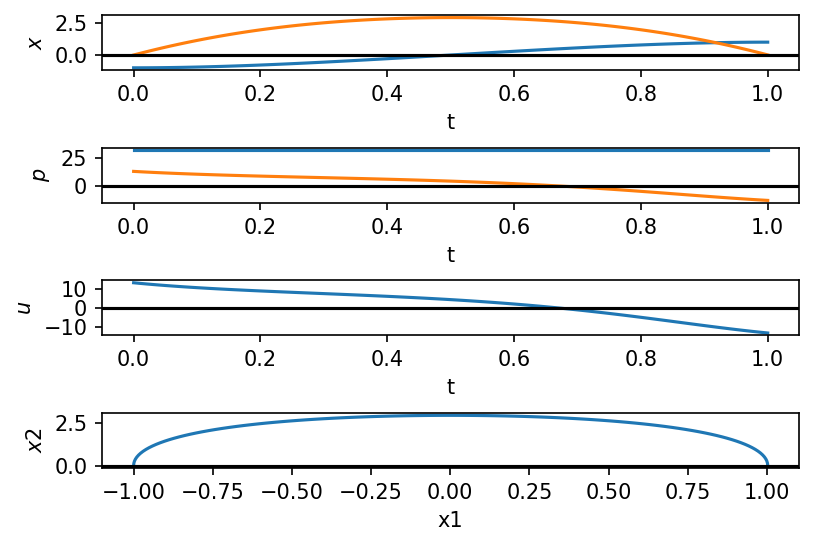

In [21]:
# Plot solution
plotSolution(p0_rk4)

## Step 3: Replacing the Newton solver

In this part, we define a Newton method to solve the shooting equations. In the description of the shooting equations, we use the rk4 integrator to compute the flow of the Hamiltonian system.

### Preliminaries

The following methods may be used to print information during the interations of the Newton solver.

In [50]:
def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

@static_vars(counter=0)
def callbackPrint(x,f):
    if(callbackPrint.counter==0):
        print('\n     Calls  |f(x)|                 |x|\n ')
    print('{0:10}'.format(callbackPrint.counter+1) + \
            '{0:23.15e}'.format(np.linalg.norm(f)) + \
            '{0:23.15e}'.format(np.linalg.norm(x)))
    callbackPrint.counter += 1

### Coding the Newton solver

Let us recall the [Newton method](https://en.wikipedia.org/wiki/Newton%27s_method). Let us consider the nonlinear system of equations

$$
    f(x) = 0_{\mathrm{R}^n},
$$

with $f : \Omega \subset \mathrm{R}^n \to \mathrm{R}^n$, differentiable on the open set $\Omega$. The Newton method consists in solving iteratively a linear approximation of the system of equations. Let $k$ be the current iteration and $x^{(k)}$ the current iterate. The linear approximation reads

$$
    f(x^{(k)} + d) = f(x^{(k)}) + J_f(x^{(k)}) d + o(||d||), \quad d \in \mathrm{R}^n,
$$

where $J_f$ is the Jacobian of $f$ and where we have used the [Landau notation](https://en.wikipedia.org/wiki/Big_O_notation). Let us set

$$
    f_k(d) = f(x^{(k)}) + J_f(x^{(k)}) d.
$$

We update the iterate as follows:
$
    x^{(k+1)} = x^{(k)} + d^{(k)},
$
where $d^{(k)}$ is the solution of 
$
    f_k(d) = 0.
$

This system being linear, if $J_f(x^{(k)})$ is invertible, then the next iterate is given by

$$
    x^{(k+1)} = x^{(k)} - \left( J_f(x^{(k)}) \right)^{-1} f(x^{(k)}).
$$

<div class="alert alert-info">

**_Question 6:_**
    
Complete the code of `newton` (see the documentation of the function for details).
      
</div>

In [51]:
# ----------------------------
# Answer 6 to complete here
# ----------------------------
#
# Newton solver
#
def newton(f, jf, x0):
    '''
        Solve f(x) = 0, with a Newton method, starting from the iterate x0.
        
        Usage:
        
            x, y, flag, it = newton(f, jf, x0)
        
        Newton iteration:
        
            x_{k+1} = x_k - d_k, d_k solution of f'(x_k) d = - f(x_k)
        
        Inputs: 
        
            - f  : function f(x)
            - jf : Jacobian of f
            - x0 : initial iterate
            
        Returns:
        
            - x    : solution of f(x)=0 if convergence, last iterate otherwise
            - y    : f(x)
            - flag : -1 if itermax is reached,
                      1 if ||d|| < tolx * max(||x||, 1) at the last iterate
            - it   : number of iterations
        
        Numpy use:
        
            - linear.solve to solve Ax=b.
            - linalg.norm to compute the norm of a vector
            - maximum
        
        Remark: you can use callbackPrint to plot infos during the iterations.
        Do not forget to reset the counter: callbackPrint.counter=0 before return.
        
    '''
    tolx    = 1e-6
    itermax = 50
    
    i    = 0
    x    = x0
    flag = 0
    
    while flag == 0:
    
        # get f(x) and Jf(x)
        A = jf(x) ### TO COMPLETE
        b = f(x) ### TO COMPLETE
        
        # print
        callbackPrint(x, b)
        
        # solve the linear system
        d = np.linalg.solve(A,b) ### TO COMPLETE
        
        # update the iterate
        x -= d ### TO COMPLETE
        
        # test stop criterion
        i = i + 1 
        if(i==itermax):
            flag = -1
        ### TO COMPLETE
        if np.linalg.norm(d) < tolx * max(np.linalg.norm(x), 1):
            flag = 1
        ### END TO COMPLETE
   
    # print
    b = f(x)
    callbackPrint(x, b)
    
    # reset counter
    callbackPrint.counter=0
    
    # return
    return x, b, flag, i

In [52]:
# Test on the functions cosinus and sinus
print(newton(lambda x: np.array([np.cos(x[0]), np.sin(x[1])]),   \
             lambda x: np.array([[-np.sin(x[0]), 0], [0, np.cos(x[1])]]), \
             np.array([1.0, 1.0])))


     Calls  |f(x)|                 |x|
 
         1  1.000000000000000e+00  1.414213562373095e+00
         2  5.337630192336734e-01  1.734119814433538e+00
         3  6.588879577933728e-02  1.572058663656674e+00
         4  9.572191917890302e-05  1.570796329712061e+00
         5  2.923566265536036e-13  1.570796326794897e+00
         6  6.123233995736766e-17  1.570796326794897e+00
(array([1.57079633, 0.        ]), array([6.123234e-17, 0.000000e+00]), 1, 5)


### Solve the shooting equations

In [53]:
# Jacobian of the shooting function
def jshoot(p0):
    """jac = jshoot(p0)

    Jacobian of shooting function wrt. p0
    """
    n = dimx
    dp0 = np.eye(n)
    jac = np.zeros((n, n))

    for i in range(0, n):
        _, jac[:, i] = shoot((p0, dp0[i, :]))

    return jac

In [54]:
# Resolution of the shooting function
p0_guess = np.array([0.1, 0.1])
p0_sol, S_sol, flag, it = newton(shoot_rk4, jshoot, p0_guess)
print('\n p0_sol     =', p0_sol, \
      '\n shoot      =', shoot(p0_sol), \
      '\n flag       =', flag, \
      '\n iterations =', it)


     Calls  |f(x)|                 |x|
 
         1  1.967300774283730e+00  1.414213562373095e-01
         2  7.385204030659524e+00  2.683757631301586e+01
         3  3.301727242107171e+00  2.067764703459640e+01
         4  5.124424337033879e-01  3.243074079406654e+01
         5  1.072191710683171e-02  3.438919455778398e+01
         6  9.531293522933587e-06  3.443203660979187e+01
         7  9.649733083213373e-08  3.443211793181983e+01
         8  1.438291368008928e-10  3.443211783256179e+01

 p0_sol     = [31.89790591 12.96512003] 
 shoot      = [0.00280851 0.00846786] 
 flag       = 1 
 iterations = 7


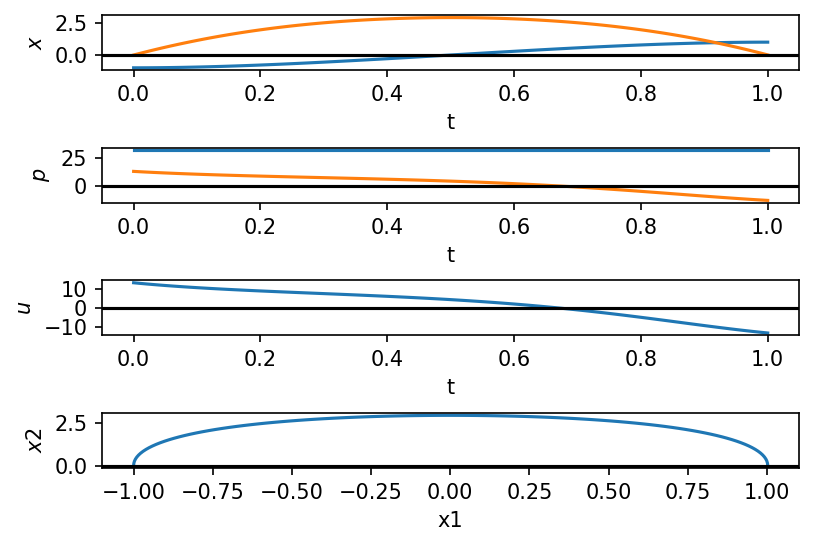

In [55]:
# Plot solution
plotSolution(p0_sol)